Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
Обучить word2vec на фразах персонажей
Построить word cloud по самым частотным словам (top 1000)
Найти самые близкие слова для:
homer - marge + bart
bart - lisa + school
marge - homer + home
Попробовать построить классификатор сообщение Bart/Lisa c использованием полученых эмбеддингов

In [63]:
import pandas as pd
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import numpy as np
import multiprocessing
from gensim.models import Word2Vec
from collections import Counter
cores = multiprocessing.cpu_count()
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
#file reading

In [3]:
data = pd.read_csv('simpsons_script_lines.csv', usecols=['normalized_text', 'raw_character_text'])

In [4]:
data.dropna(inplace = True)

In [5]:
#functions
def stop_filter(res, stop_words):
    return [word for word in res if not word in stop_words] 

def lemmatization(res, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in res]

def bigram_creation(res):
    return [' '.join(x) for x in list(nltk.bigrams(res))]

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natalka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/natalka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/natalka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
#tokenization, removing stop words

In [9]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words) + ['oh', 'know', 'thanks', 'hey']
data['words'] = [word_tokenize(str(x)) for x in data['normalized_text']]
data['words'] = data['words'].apply(lambda x: stop_filter(x, stop_words))

In [10]:
#lemmatization (also we can use stemming in this case)

In [11]:
data['words'] = data['words'].apply(lambda x: lemmatization(x, lemmatizer))

In [12]:
#creating bigrams

In [13]:
data['words_bigram'] = data['words'].apply(lambda x: bigram_creation(x))

In [14]:
data['words'] = data['words'] + data['words_bigram']

In [15]:
#word2vec gensim

In [16]:
data_for_gensim = list(data['words'].values)

In [17]:
all_words = np.concatenate(data_for_gensim)

In [18]:
word_freq_dict = Counter(all_words)

In [19]:
sum(word_freq_dict.values())

1321560

In [20]:
sorted(word_freq_dict.items(), key=lambda item: item[1], reverse = True)[:10]

[('im', 9434),
 ('well', 7029),
 ('dont', 6879),
 ('like', 6143),
 ('get', 5524),
 ('youre', 5038),
 ('one', 4957),
 ('got', 4624),
 ('--', 4509),
 ('thats', 4489)]

In [21]:
z = 7000/sum(word_freq_dict.values())
p = ((z/0.00005)**(1/2)+1)*0.00005/z
print(p)

0.10659790635264339


In [43]:
#sample - sample search was shown above
#negative -  20 is OK as it was mentioned in original paper
#other parametres was borrowed from kaggle
w2v_model = Word2Vec(min_count=5, window=7,size=300,sample=5e-5, alpha=0.03, 
                     min_alpha=0.0007, negative=20,workers=cores-1)

In [44]:
w2v_model.build_vocab(data_for_gensim)

In [45]:
w2v_model.train(data_for_gensim, total_examples=w2v_model.corpus_count, epochs=30)

(15114457, 39646800)

In [46]:
#Word similarity

In [47]:
#homer - marge + bart bart - lisa + school marge - homer + home 

In [48]:
w2v_model.wv.most_similar(positive=['homer', 'marge'], negative=['bart'])

[('homer homer', 0.5352832078933716),
 ('homer im', 0.4722553491592407),
 ('marge marge', 0.4462618827819824),
 ('husband', 0.44119465351104736),
 ('homer see', 0.43622347712516785),
 ('wife', 0.4253312945365906),
 ('gee homer', 0.41382575035095215),
 ('love homer', 0.41172534227371216),
 ('marge homer', 0.4086543023586273),
 ('right homer', 0.4070640802383423)]

In [49]:
w2v_model.wv.most_similar(positive=['bart', 'lisa'], negative=['school'])

[('maggie', 0.6124227046966553),
 ('lisa maggie', 0.5779250860214233),
 ('marge bart', 0.5626797676086426),
 ('bart lisa', 0.52897047996521),
 ('lisa lisa', 0.5244735479354858),
 ('maggie simpson', 0.5191347599029541),
 ('hi bart', 0.504185140132904),
 ('bart bart', 0.4931791424751282),
 ('simpson bart', 0.4929419457912445),
 ('lisa bart', 0.4926031231880188)]

In [50]:
w2v_model.wv.most_similar(positive=['marge', 'home'], negative=['homer'])

[('come home', 0.49445125460624695),
 ('go home', 0.471233606338501),
 ('nursing', 0.46202874183654785),
 ('home early', 0.4591820240020752),
 ('got home', 0.45222193002700806),
 ('home ill', 0.44040393829345703),
 ('cook', 0.4187390208244324),
 ('couch', 0.4185875654220581),
 ('home family', 0.4180086851119995),
 ('get home', 0.41419270634651184)]

In [ ]:
#Word Cloud

In [55]:
cloudwords = sorted(word_freq_dict.items(), key=lambda item: item[1], reverse = True)[:1000]

In [57]:
cloudwords = [x[0] for x in cloudwords]

In [60]:
cloudwords = ', '.join([x for x in all_words if x in cloudwords])

In [62]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(cloudwords) 

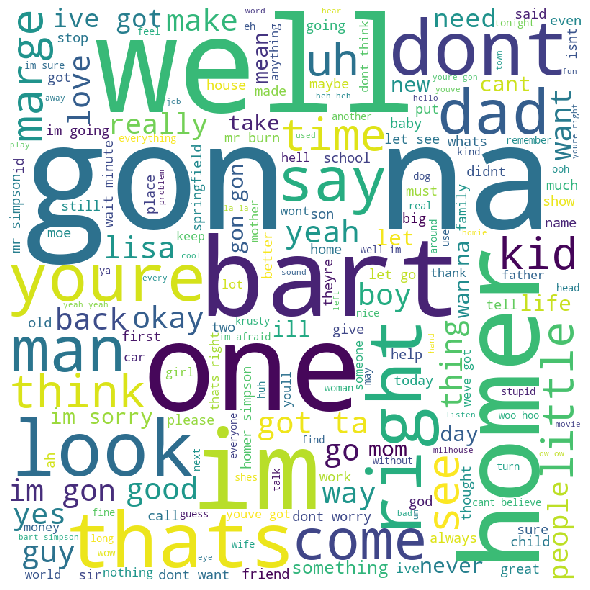

In [64]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 